# Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime
from multiprocessing import Pool

In [8]:
from array import array
import numpy as np
import root_numpy as rtnp
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
from progressBar import ProgressBar

In [27]:
import uproot as ur
import ROOT as rt
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH2D, create_TH1D, std_color_list, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic

rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis, Handle, Events

webDir = '/storage/user/ocerri/public_html/BPH_RDst/pythiaProcessesComparison/'

In [19]:
def make_comp_plot_1D(inputs, #[x, label, color=-1 (auto), ]
                      transformX = None,
                      binning=[None, None, None],
                      setLog = '',
                      miny = 0,
                      axis_title = ['', ''],
                      scale_histo = 'norm',
                      opt='overflow+underflow',
                      leg_loc=[0.6, 0.7, 0.9, 0.93], # x0, y0, w, h
                      tag=''
                     ): 
    
    if not leg_loc is None:
        leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[0] + leg_loc[2], leg_loc[1] + leg_loc[3])
        leg.SetBorderSize(0)
        leg.SetFillStyle(0)
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hList = []
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        if isinstance(scale_histo, list):
            auxScale = scale_histo[i]
        else:
            auxScale = scale_histo
        h = create_TH1D(x, 
                        binning=binning if i==0 else hList[0].binning, 
                        axis_title=axis_title,
                        scale_histo=auxScale, 
                        widthNorm=True,
                        opt=opt,
                       )
        h.SetLineColor(colors[i])
        if not leg_loc is None:
            leg.AddEntry(h, label, 'lp')
        hList.append(h)
            
    m = SetMaxToMaxHist(hList)
    hList[0].GetYaxis().SetRangeUser(miny, m)
    c = drawOnCMSCanvas(CMS_lumi, hList, 'same', tag=tag)
    leg.Draw()
    
    if 'x' in setLog: c.SetLogx()
    if 'y' in setLog: c.SetLogy()
    
    c.dnd = [hList, leg]
    return c

# Inputs

In [10]:
ds = {}
ds['mu_HardQCD'] = DSetLoader('B0_MuNuDmst_PUc0')
ds['mu_SoftQCD'] = DSetLoader('B0_MuNuDmst_SoftQCDall_PUc0')

In [ ]:
base = '/mnt/hadoop/store/user/ocerri/cmsMC_private_PUc0_10-2-3/'
loc = {}

loc['mu_HardQCD'] = base + 'BP_Tag_B0_MuNuDmst_Hardbbbar*/*/*/out_MINIAODSIM_*.root'
loc['mu_SoftQCD'] = base + 'BP_Tag_B0_MuNuDmst_SoftQCDall*/*/*/out_MINIAODSIM_*.root'

In [ ]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'SIM')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'SIM')]

In [ ]:
eff = {}
nMax = 100
for n, ftempl in loc.iteritems():
    print n
    N_cuts = 0
    N_gen = 0
    flist = glob(ftempl)
    if len(flist) > nMax:
        flist = np.random.choice(flist, nMax)
    for fn in flist:
        for lumi in Lumis(fn):
            prods = {}
            for k,v in handle.iteritems():
                lumi.getByLabel(v[1], v[0])
                prods[k] = v[0].product()
            N_cuts += prods['genFilter'].numEventsPassed()
            N_gen += prods['genFilter'].numEventsTotal()
           
    e, de = getEff(N_cuts, N_gen)
    eff[n] = [e, de]
    print 'eff generator: {:1.2e} +/- {:1.2e} ({:1.1e})'.format(e, de, de/e)
    print '\n'

# Extract informations from edm

In [ ]:
def extractFromFile(inputs):
    iJob = inputs[0]
    fn = inputs[1]
    nMax = inputs[2]
    
    events = Events(fn)
    nTot = events.size()
    nOut = float(min(nTot, nMax))
    outDs = np.zeros((int(nOut), 4))
    for iEv, event in enumerate(events):
        if iEv ==0 or (iEv+1) % int(nOut/2.0) == 0:
            pass
#             print '{}: {:.0f} %'.format(iJob, 100.*(iEv+1)/nOut)

        handle = Handle('vector<reco::GenParticle>')
        event.getByLabel(('prunedGenParticles', '', 'PAT'), handle)

        ptB = []
        etaB = []
        pt = []
        eta = []
        for p in handle.product():
            if not p.pdgId() == 511:
                continue
            ptB.append(p.pt())
            etaB.append(p.eta())
            for d in p.daughterRefVector():
                if d.pdgId() == -13:
                    pt.append(d.pt())
                    eta.append(d.eta())
                elif d.pdgId() == -15:
                    for dd in d.daughterRefVector():
                        if dd.pdgId() == -13:
                            pt.append(dd.pt())
                            eta.append(dd.eta())
        if len(pt) < 2:
            idx = 0
        else:
            pt = np.array(pt)
            eta = np.array(eta)
            sel = np.logical_and(pt > 6.7, np.abs(eta) < 1.6)

            if np.sum(sel) > 0:
                idx = np.random.choice(np.nonzero(sel)[0])
            else:
                idx = np.random.choice(pt.shape[0])
        outDs[iEv, 0] = pt[idx]
        outDs[iEv, 1] = eta[idx]
        outDs[iEv, 2] = ptB[idx]
        outDs[iEv, 3] = etaB[idx]

        if iEv == nMax - 1:
            break
    print 'Job {} done ({} events)'.format(iJob, iEv)
    return [outDs, iEv+1]

In [ ]:
nMax = 1e9
nFileMax = {'mu_SoftQCD': 5000, 'mu_HardQCD':100}
dset = {}
nTot = {}
recreate = []#['mu_SoftQCD', 'mu_HardQCD']

for n, ftempl in loc.iteritems():
    print n
    
    idx = ftempl.find('10-2-3') + len('10-2-3')
    outname = ds[n].candLoc + ds[n].full_name+'/miniaodGenInfo.pkl'
    if os.path.exists(outname) and not n in recreate:
        print 'Loading file'
        nTot[n], outDs = pickle.load( open(outname, 'rb') )
    else:
        inputs = []
        
        for i, fn in enumerate(glob(ftempl)):
            inputs.append([str(i), fn, nMax])
            if i == nFileMax[n]-1:
                break
            
        p = Pool(min(20,len(inputs)))
        outputs = p.map(extractFromFile, inputs)
        print 'Concatenating outpusts'
        outDs = np.concatenate(tuple([o[0] for o in outputs]))
        nTot[n] = np.sum([o[1] for o in outputs])
        
        pickle.dump( [nTot[n], outDs], open( outname, 'wb' ) )
    dset[n] = outDs
    print 'Tot candidates: '+ str(outDs.shape[0])
    print 'Done\n\n'

# Analyze gen data

In [22]:
txt = rt.TLatex()
txt.SetTextAlign(12)
txt.SetTextSize(0.04)
txt.SetTextFont(42)

In [23]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [ ]:
# make_comp_plot_1D(
#     [
#         [dset['mu'][:,0], label_dic['mu']],
#         [dset['tau'][:,0], label_dic['tau']],
#     ],
#     binning=np.logspace(-2, 2, 70), setLog='xy', miny=1e-5,
#     axis_title = ['Muon p_{T} [GeV]', 'Normalized events'],
#     leg_loc=[0.2, 0.75, 0.2, 0.15]
# )


In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,0], 'HardQCD'],
        [dset['mu_SoftQCD'][:,0], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 20, 70), setLog='', miny=1e-5,
    axis_title = ['Gen muon p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [np.abs(dset['mu_HardQCD'][:,1]), 'HardQCD'],
        [np.abs(dset['mu_SoftQCD'][:,1]), 'SoftQCD'],
    ],
    binning=np.linspace(0, 1.6, 70), setLog='y', miny=1e-5,
    axis_title = ['Gen muon #eta', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,2], 'HardQCD'],
        [dset['mu_SoftQCD'][:,2], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 50, 50), setLog='', miny=1e-5,
    axis_title = ['Gen B p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.6, 0.75, 0.2, 0.15]
)

In [ ]:
make_comp_plot_1D(
    [
        [dset['mu_HardQCD'][:,3], 'HardQCD'],
        [dset['mu_SoftQCD'][:,3], 'SoftQCD'],
    ],
    binning=np.linspace(-2, 2, 50), setLog='', miny=1e-5,
    axis_title = ['B #eta', 'Normalized events'],
    leg_loc=[0.8, 0.8, 0.2, 0.15]
)

# Analyze reco data

In [25]:
binning = {'q2': array('d', [0, 3.5, 6, 9.4, 12])}
binning['M2_miss'] = [
        array('d', [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4] ),
        array('d', [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8] ),
        array('d', list(np.arange(0, 6, 0.2)) + [8] ),
        array('d', list(np.arange(0, 7.8, 0.2)) + [8] ),
    ]
binning['Est_mu'] = [
        array('d', [0.3] + list(np.arange(0.5, 2.3, 0.05)) + [2.3] ),
        array('d', [0.3] + list(np.arange(0.5, 2.2, 0.05)) + [2.2] ),
        array('d', [0.3] + list(np.arange(0.5, 2.1, 0.05)) + [2.1] ),
        [24, 0.3, 2.0],
    ]

xAx_title = {'M2_miss':'m^{2}_{miss} [GeV^{2}]', 'Est_mu':'E_{#mu}* [GeV]'}

In [35]:
category = 'High'

In [36]:
dsHard = pd.DataFrame(rtnp.root2array(ds['mu_HardQCD'].skimmed_dir + '/{}_bare.root'.format(category)))
dsSoft = pd.DataFrame(rtnp.root2array(ds['mu_SoftQCD'].skimmed_dir + '/{}_bare.root'.format(category)))

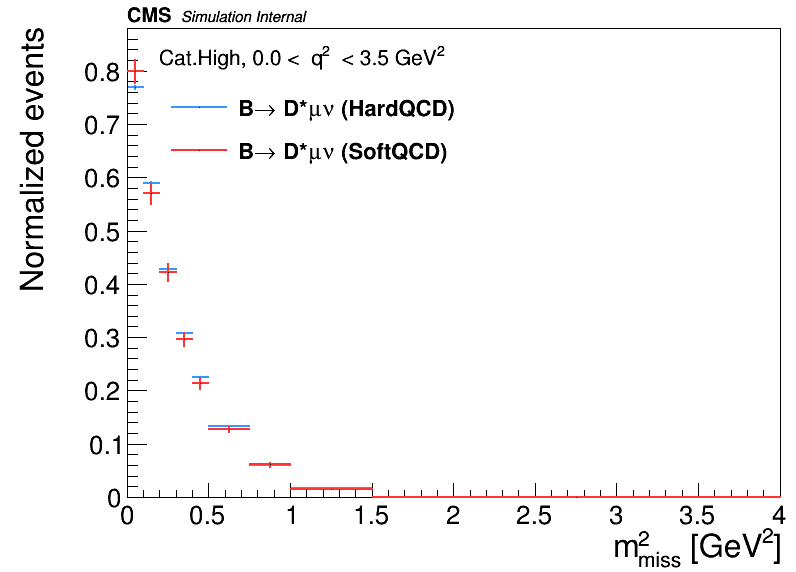

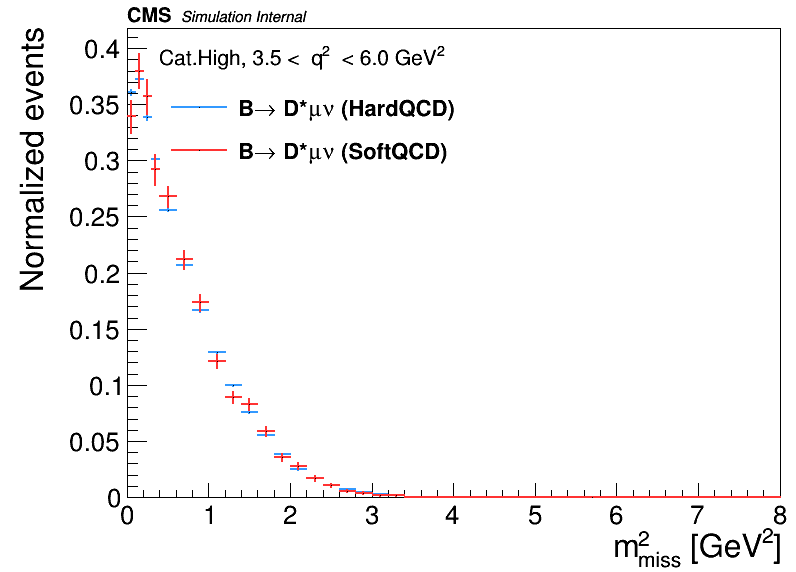

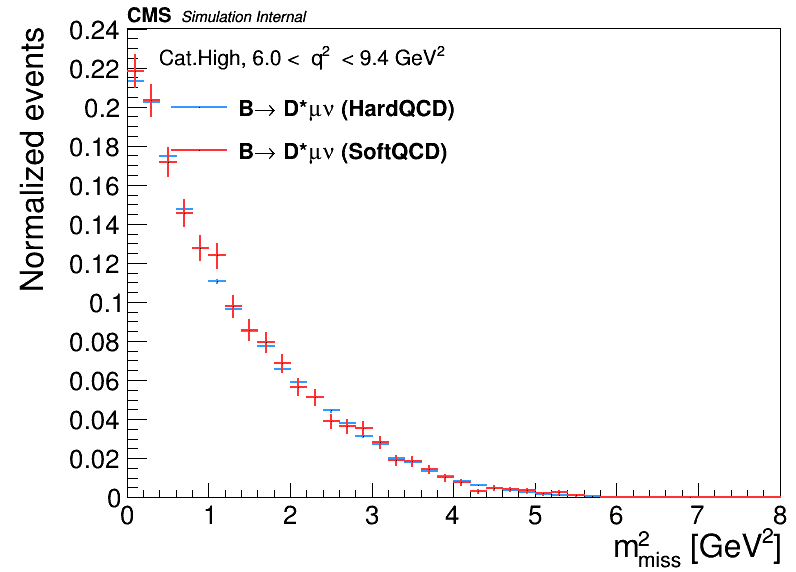

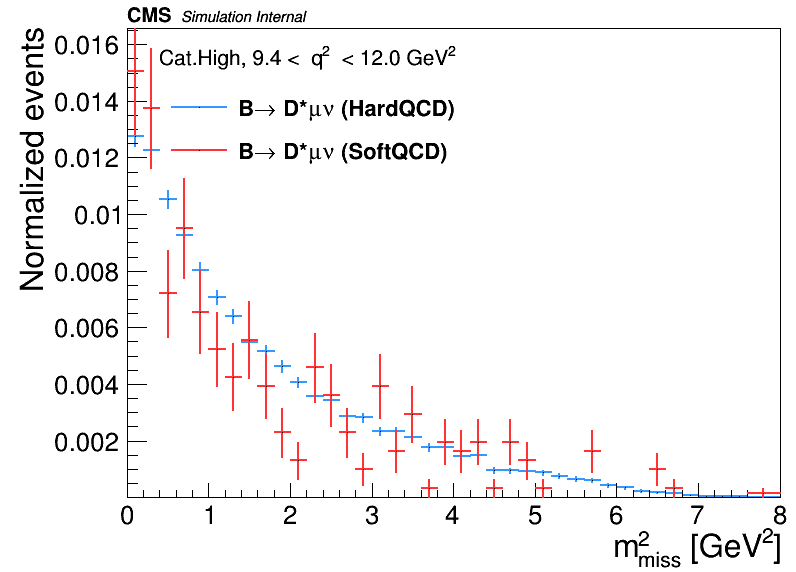

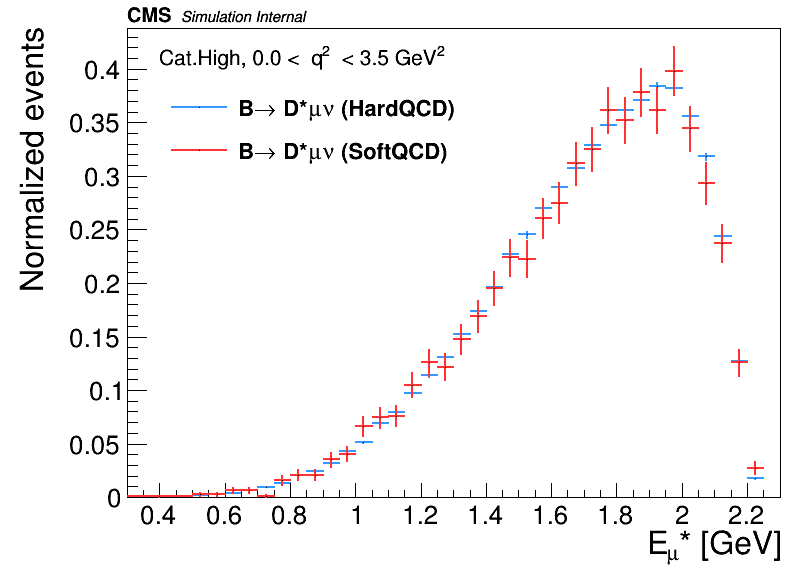

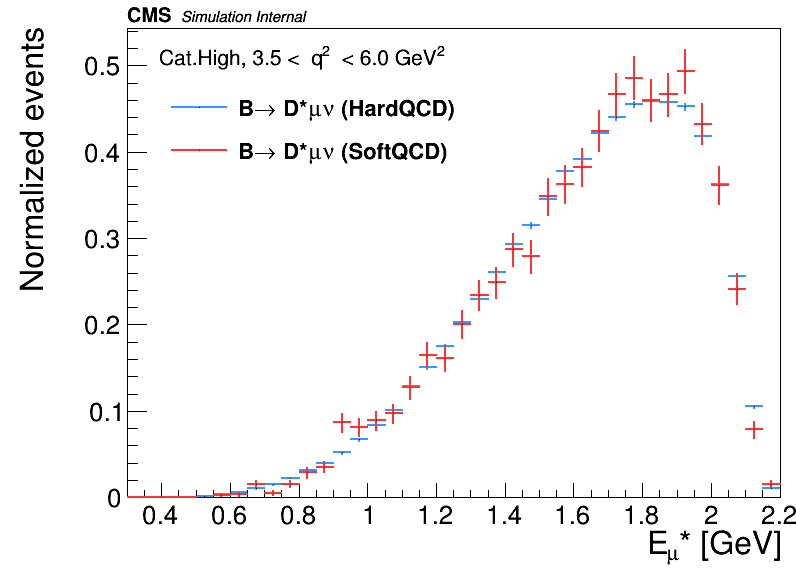

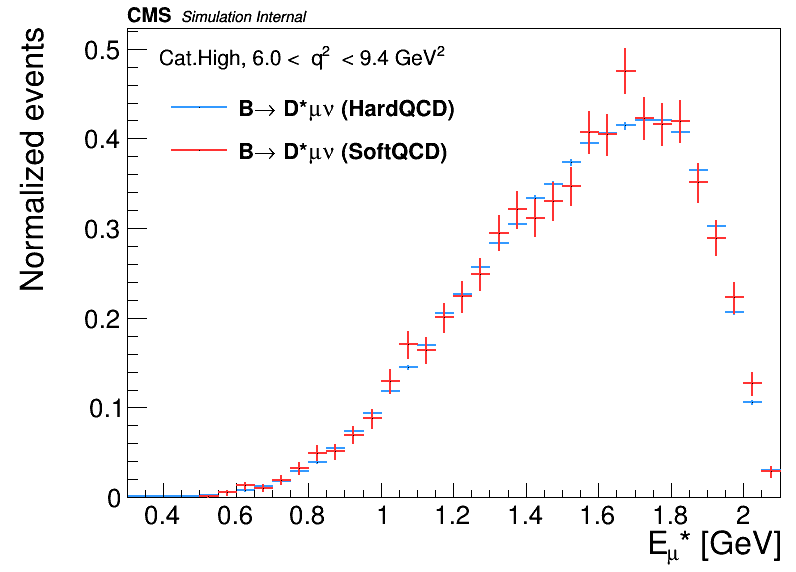

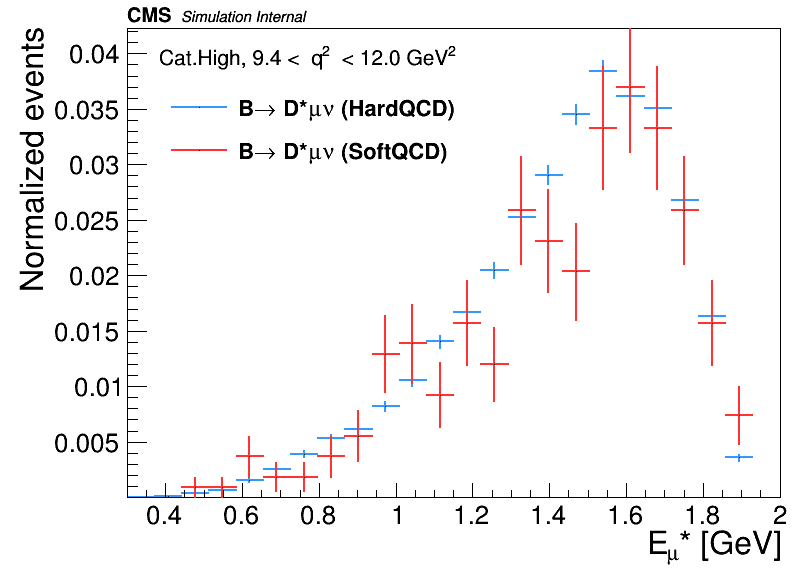

In [37]:
canvasOut = []
for var in ['M2_miss', 'Est_mu']:
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)
        selSoft = np.logical_and(dsSoft['q2'] > q2_l, dsSoft['q2'] <= q2_h)
        selHard = np.logical_and(dsHard['q2'] > q2_l, dsHard['q2'] <= q2_h)

        c = make_comp_plot_1D(
            [
                [dsHard[var][selHard], 'B#rightarrow D*#mu#nu (HardQCD)'],
                [dsSoft[var][selSoft], 'B#rightarrow D*#mu#nu (SoftQCD)'],
            ],
            scale_histo = [1./selHard.shape[0], 1./selSoft.shape[0]],
            binning=binning[var][i_q2], 
            setLog='', miny=1e-6,
            axis_title = [xAx_title.get(var, var), 'Normalized events'],
            leg_loc=[0.25, 0.7, 0.35, 0.15],
            tag=category +'_'+ var+'_q2bin'+str(i_q2)
        )
        txt.DrawLatexNDC(0.2, 0.95, 'Cat.' + category.capitalize() + ', ' + q2_txt)

        c.SaveAs(webDir + category + '_' + var + '_q2bin'+str(i_q2) + '.png')
        canvasOut.append(c)